# 🕰️ Amazon Chronos: Generative AI Time Series Forecasting

Generative AI represents a groundbreaking frontier in time series forecasting, promising to reshape our approach to predictive modeling across diverse domains. Unlike traditional forecasting methods such as ARIMA and exponential smoothing—which rely on rigid statistical assumptions and predefined models—generative AI introduces a dynamic, adaptive paradigm for understanding and predicting complex temporal patterns.

Key Transformative Aspects:
- Breaks traditional constraints of statistical forecasting
- Learns intricate, non-linear relationships in data
- Generates probabilistic predictions with nuanced uncertainty
- Adapts to high-dimensional and rapidly evolving datasets

Technical Foundations:
Generative AI leverages advanced deep learning techniques like:
- Transformer models
- Generative Adversarial Networks (GANs)
- Variational Autoencoders
- Large language model architectures

Breakthrough Capabilities:
- Uncover hidden structures in complex time series data
- Generate multiple plausible future scenarios
- Adapt to non-stationary and complex temporal dynamics
- Provide probabilistic forecasts with uncertainty quantification

Potential Impact Domains:
- Financial markets and investment forecasting
- Energy consumption prediction
- Climate and weather modeling
- Demand planning and supply chain optimization
- Healthcare and medical trend analysis

By transcending the limitations of traditional statistical methods, generative AI opens new frontiers in predictive analytics, offering unprecedented insights and accuracy in time series forecasting.


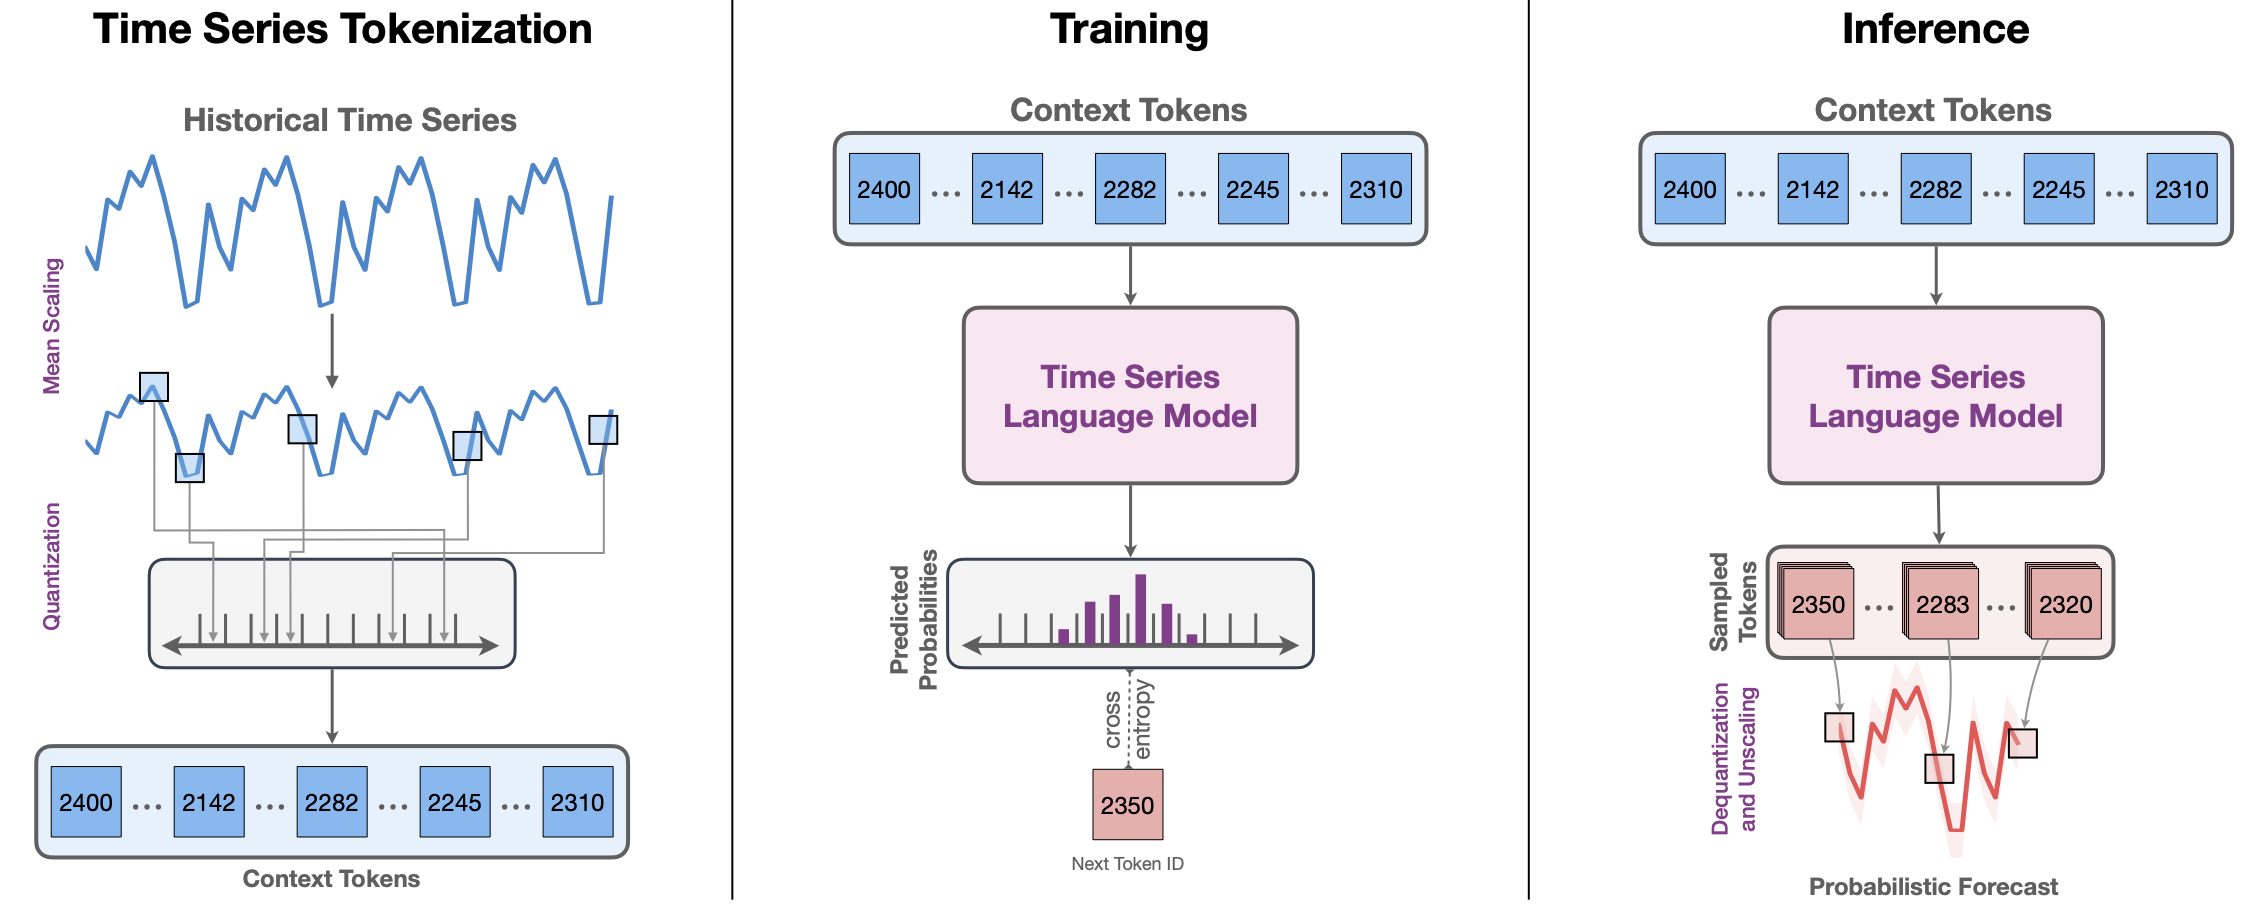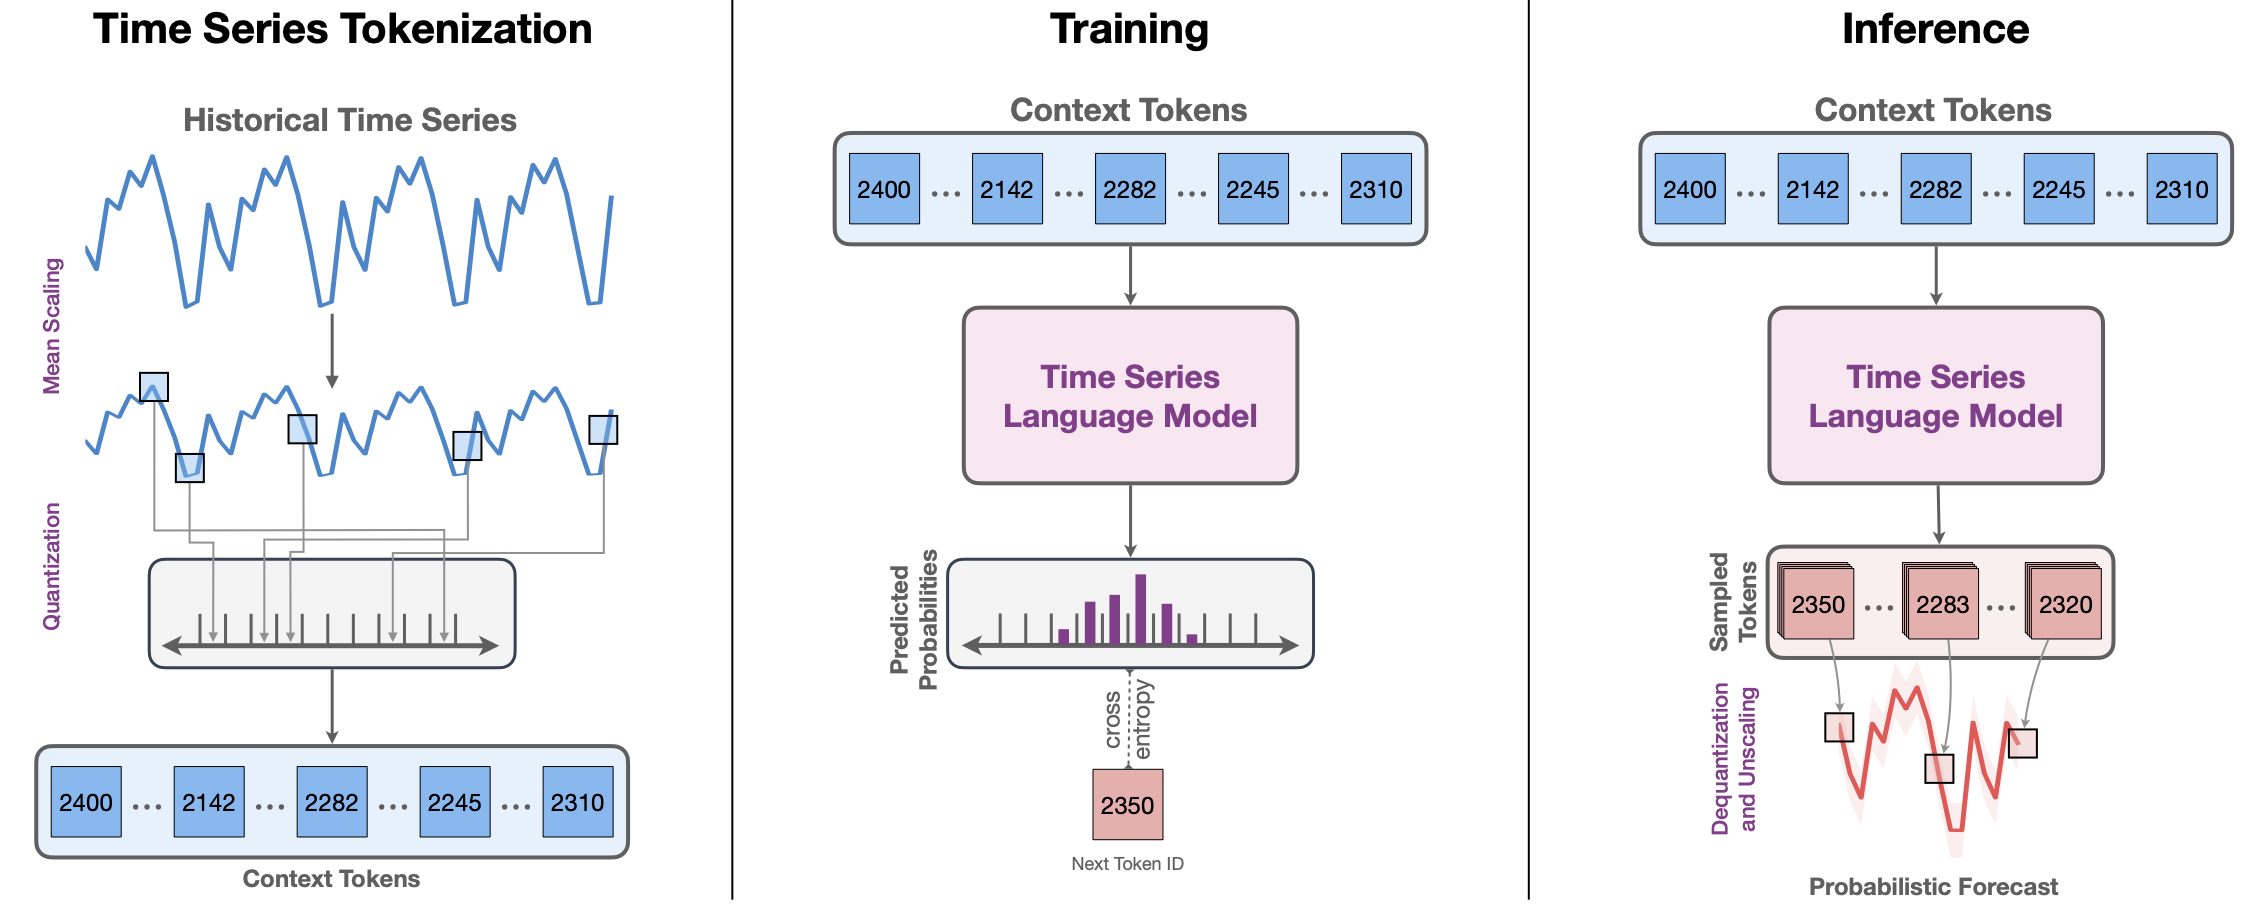

Chronos is a family of pretrained time series forecasting models based on language model architectures. A time series is transformed into a sequence of tokens via scaling and quantization, and a language model is trained on these tokens using the cross-entropy loss. Once trained, probabilistic forecasts are obtained by sampling multiple future trajectories given the historical context. Chronos models have been trained on a large corpus of publicly available time series data, as well as synthetic data generated using Gaussian processes.

# Installing the Chronos Library and importing the necessary libraries

In [1]:
# Install the chronos library and time series database
!pip install -q git+https://github.com/amazon-science/chronos-forecasting.git
!pip install -q tsdb

In [2]:
# Libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import ParameterGrid
import tsdb
from chronos import ChronosPipeline
from datetime  import datetime
import torch
import random
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# Loading the Data 

In [3]:
#Check for duplicates 
df = pd.read_csv('/kaggle/input/hourly-energy-consumption/PJME_hourly.csv')
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.set_index('Datetime', inplace=True)
duplicates = df.index[df.index.duplicated()]
print(duplicates)


DatetimeIndex(['2014-11-02 02:00:00', '2015-11-01 02:00:00',
               '2016-11-06 02:00:00', '2017-11-05 02:00:00'],
              dtype='datetime64[ns]', name='Datetime', freq=None)


In [4]:
df = df[~df.index.duplicated(keep='first')]

In [5]:
df = df.groupby(df.index).mean()

In [6]:
df.asfreq('h')

,PJME_MW
Datetime,
2002-01-01 01:00:00,30393.0
2002-01-01 02:00:00,29265.0
2002-01-01 03:00:00,28357.0
2002-01-01 04:00:00,27899.0
2002-01-01 05:00:00,28057.0
...,...
2018-08-02 20:00:00,44057.0
2018-08-02 21:00:00,43256.0
2018-08-02 22:00:00,41552.0


# Checking for Outliers and Reviewing Seasonality 

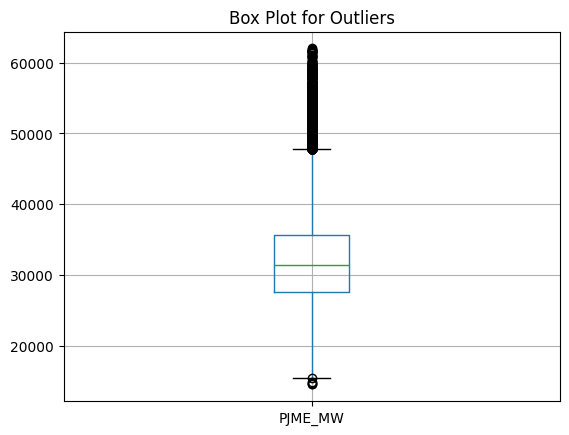

In [7]:
df.boxplot(column='PJME_MW')
plt.title("Box Plot for Outliers")
plt.show()

In [8]:
from scipy.stats import zscore

df['z_score'] = zscore(df['PJME_MW'])
outliers = df[df['z_score'].abs() > 3]
print(outliers)


                     PJME_MW   z_score
Datetime                              
2002-06-26 13:00:00  51677.0  3.031705
2002-06-26 14:00:00  52637.0  3.180224
2002-06-26 15:00:00  52938.0  3.226790
2002-06-26 16:00:00  52894.0  3.219983
2002-06-26 17:00:00  52148.0  3.104572
...                      ...       ...
2018-07-16 15:00:00  52742.0  3.196468
2018-07-16 16:00:00  53408.0  3.299502
2018-07-16 17:00:00  53764.0  3.354578
2018-07-16 18:00:00  53352.0  3.290839
2018-07-16 19:00:00  52226.0  3.116639

[1318 rows x 2 columns]


In [9]:
df=df.query('PJME_MW > 19000').copy()
df.drop('z_score',axis=1,inplace=True)

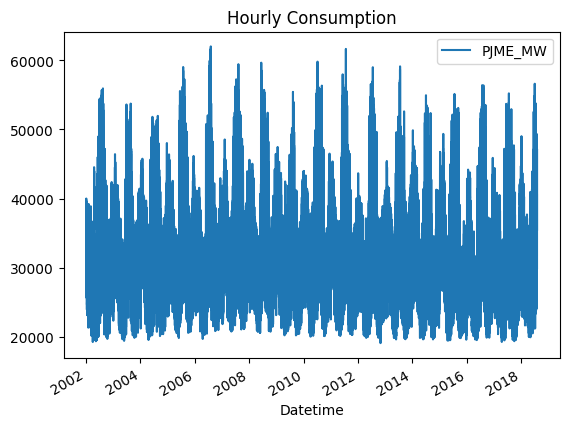

In [10]:
# Plot the hourly temperature data
df.plot(title = 'Hourly Consumption')
plt.show()

In [11]:
df.isna().sum()

PJME_MW    0
dtype: int64

# Parameter tuning 

In [12]:
# Forecast horizon (number of hours to predict) and stride for sliding windows
forecast_horizon = 48 
stride = 8 

df.index = pd.to_datetime(df.index)
df = df[['PJME_MW']] 

# Define start and end for the sliding windows
start_date = df.index[-(forecast_horizon * 10)] 
end_date = df.index[-1] 

pipeline = ChronosPipeline.from_pretrained("amazon/chronos-t5-base",device_map="auto")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
# Define the parameter grid for hyperparameter tuning
param_grid = {
    "temperature": [0.1, 0.5, 1.0, 1.5],  # Controls randomness in the predictions
    "top_k": [10, 30, 50, 100],          # Number of top predictions to consider
    "top_p": [0.1, 0.5, 0.75, 1.0],      # Cumulative probability for sampling predictions
    "num_samples": [5, 10, 20, 50]        # Number of samples to draw for each prediction
}

# Generate all possible combinations of hyperparameters from the grid
param_combinations = list(ParameterGrid(param_grid))

random.seed(1502)  
sampled_combinations = random.sample(param_combinations, 10)

# Define the function for forecasting and evaluation
def evaluate_model(pipeline, df, forecast_horizon, start_date, end_date, stride, params, device):

    results = []  # To store MAE results for each window
    forecasts = []  # To store forecasted values
    true_vals = []  # To store true values from the dataset

    current_start = start_date

    while current_start + pd.Timedelta(hours=forecast_horizon) <= end_date:
        # Define the context window
        context_end = current_start
        context_start = context_end - pd.Timedelta(hours=(forecast_horizon * 10))  

        # Slice the DataFrame for the context window
        context_data = df.loc[context_start:context_end, 'PJME_MW'].values
        context_tensor = torch.tensor(context_data, dtype=torch.float32).unsqueeze(0)

        # Make the forecast with the given hyperparameters
        forecast = pipeline.predict(
            context=context_tensor,
            temperature=params['temperature'],
            top_k=params['top_k'],
            top_p=params['top_p'],
            prediction_length=forecast_horizon,
            num_samples=params['num_samples'],
            limit_prediction_length=False
        )

        # Compute mean of the forecast samples
        forecast_mean = torch.mean(torch.stack([torch.tensor(sample[0]).clone().detach() for sample in forecast]), dim=0).detach().numpy()

        # Store forecast and true values
        forecasts.append(forecast_mean)
        true_vals.append(context_data[-forecast_horizon:])

        # Compute MAE for the current window
        mae = mean_absolute_error(context_data[-forecast_horizon:], forecast_mean)
        print(f"The MAE for window ending at {context_end} with params {params} is {mae:.4f}")

        # Save the result
        results.append((current_start, mae))

        # Move the window forward by the stride
        current_start += pd.Timedelta(hours=stride)

    return results, forecasts, true_vals

# Create a dictionary to store the results for each hyperparameter combination
all_results = []

# Check for GPU availability and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Loop through each sampled hyperparameter combination
#for params in sampled_combinations:
    #print(f"Evaluating with parameters: {params}")
    #results, forecasts, true_vals = evaluate_model(pipeline=pipeline,df=df,forecast_horizon=forecast_horizon,start_date=start_date,end_date=end_date, stride=stride, params=params,device=device)

    #all_results.append({"params": params,"results": results,"forecasts": forecasts,"true_vals": true_vals})

# Find the best hyperparameter combination (based on MAE)
#best_result = min(all_results, key=lambda x: min([r[1] for r in x["results"]]))  # Minimize MAE
#print(f"Best hyperparameters: {best_result['params']}")


config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/806M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

Using device: cuda
Using device: cuda


# Creating the Final pipeline for the Chronos model 

In [13]:
# Forecast horizon  and stride for sliding windows
forecast_horizon = 48  
stride = 8  

df.index = pd.to_datetime(df.index)
df = df[['PJME_MW']]  

# Define start and end for the sliding windows
start_date = df.index[-(forecast_horizon * 10)]
end_date = df.index[-1]  # The last available date in the dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

pipeline = ChronosPipeline.from_pretrained("amazon/chronos-t5-mini",device_map="auto")

def Chronos_time_series_CV(pipeline, df, forecast_horizon, start_date, end_date, stride):
    results = []  # To store MAE results for each window
    forecasts = []  # To store forecasted values
    true_vals = []  # To store true values from the dataset

    current_start = start_date

    while current_start + pd.Timedelta(hours=forecast_horizon) <= end_date:
        # Define the context window
        context_end = current_start
        context_start = context_end - pd.Timedelta(hours=(forecast_horizon * 10)) 

        # Slice the DataFrame for the context window
        context_data = df.loc[context_start:context_end, 'PJME_MW'].values

        
        context_tensor = torch.tensor(context_data, dtype=torch.float32).unsqueeze(0) 

        # Make the forecast
        forecast = pipeline.predict(
            context=context_tensor,
            temperature=0.5,
            top_k=30,
            top_p=0.75,
            prediction_length=forecast_horizon,
            num_samples=20,
            limit_prediction_length=False
             )

        # Compute mean of the forecast samples
        forecast_mean = torch.mean(torch.stack([sample[0].clone().detach() for sample in forecast]), dim=0).numpy()

        # Store forecast and true values
        forecasts.append(forecast_mean)
        true_vals.append(context_data[-forecast_horizon:]) 

        # Compute MAE for the current window
        mae = mean_absolute_error(context_data[-forecast_horizon:], forecast_mean)
        print(f"The MAE for window ending at {context_end} is {mae:.4f}")

        # Save the result
        results.append((current_start, mae))

        # Move the window forward by the stride
        current_start += pd.Timedelta(hours=stride)

    return results, forecasts, true_vals



Using device: cuda


config.json:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/81.8M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

In [14]:
# Call the function
results, forecasts, true_vals = Chronos_time_series_CV(
    pipeline=pipeline,
    df=df,
    forecast_horizon=forecast_horizon,
    start_date=start_date,
    end_date=end_date,
    stride=stride
)


The MAE for window ending at 2018-07-14 01:00:00 is 2663.2602
The MAE for window ending at 2018-07-14 09:00:00 is 3327.3654
The MAE for window ending at 2018-07-14 17:00:00 is 2393.8035
The MAE for window ending at 2018-07-15 01:00:00 is 6066.2889
The MAE for window ending at 2018-07-15 09:00:00 is 8227.7972
The MAE for window ending at 2018-07-15 17:00:00 is 3324.3608
The MAE for window ending at 2018-07-16 01:00:00 is 8329.3948
The MAE for window ending at 2018-07-16 09:00:00 is 9255.0094
The MAE for window ending at 2018-07-16 17:00:00 is 8421.0556
The MAE for window ending at 2018-07-17 01:00:00 is 5656.4456
The MAE for window ending at 2018-07-17 09:00:00 is 4737.7998
The MAE for window ending at 2018-07-17 17:00:00 is 1968.1297
The MAE for window ending at 2018-07-18 01:00:00 is 2231.6459
The MAE for window ending at 2018-07-18 09:00:00 is 5164.3236
The MAE for window ending at 2018-07-18 17:00:00 is 3479.8267
The MAE for window ending at 2018-07-19 01:00:00 is 2586.0402
The MAE 

In [15]:
# Convert the results list to a DataFrame for easier handling and visualization
results_df = pd.DataFrame(results, columns=["Date", "MAE"])

# Print the average MAE across all cross-validation splits
print(f"The average MAE is {results_df['MAE'].mean()}")
results_df

The average MAE is 4010.6776258680557


,Date,MAE
0,2018-07-14 01:00:00,2663.260213
1,2018-07-14 09:00:00,3327.365438
2,2018-07-14 17:00:00,2393.803467
3,2018-07-15 01:00:00,6066.288859
4,2018-07-15 09:00:00,8227.797201
5,2018-07-15 17:00:00,3324.360840
6,2018-07-16 01:00:00,8329.394775
7,2018-07-16 09:00:00,9255.009359
8,2018-07-16 17:00:00,8421.055583
9,2018-07-17 01:00:00,5656.445557


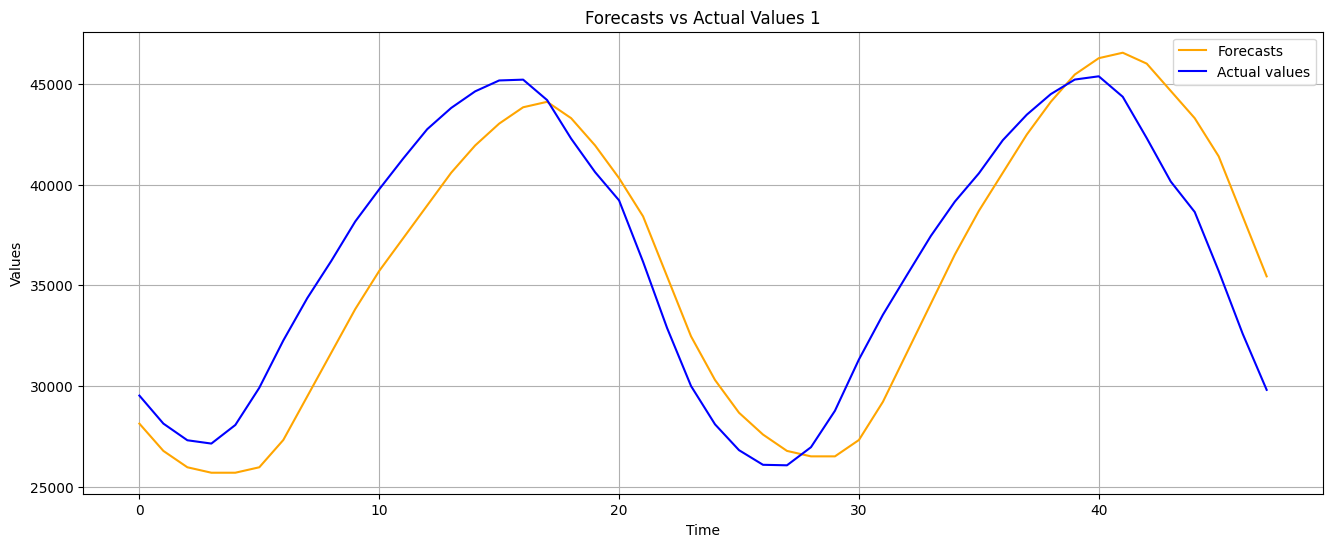

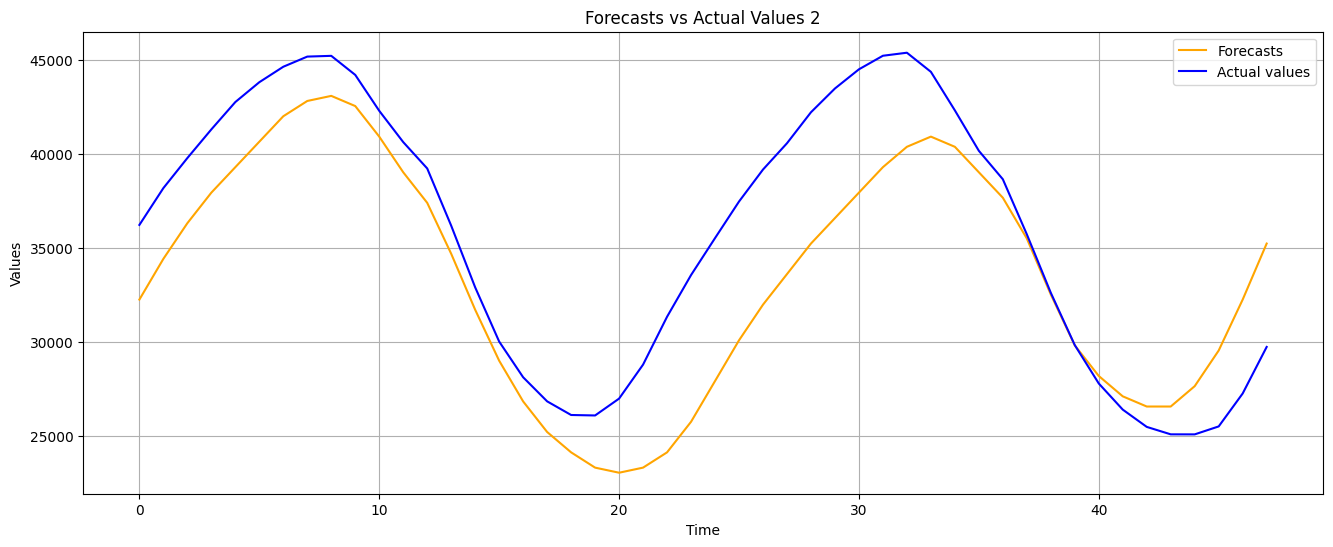

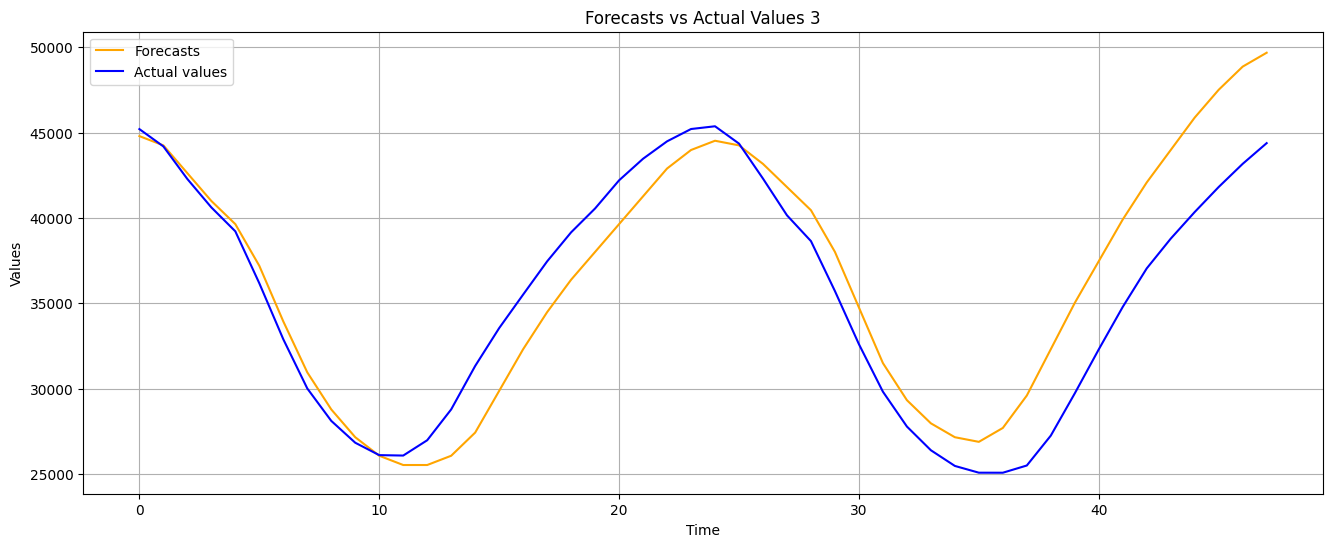

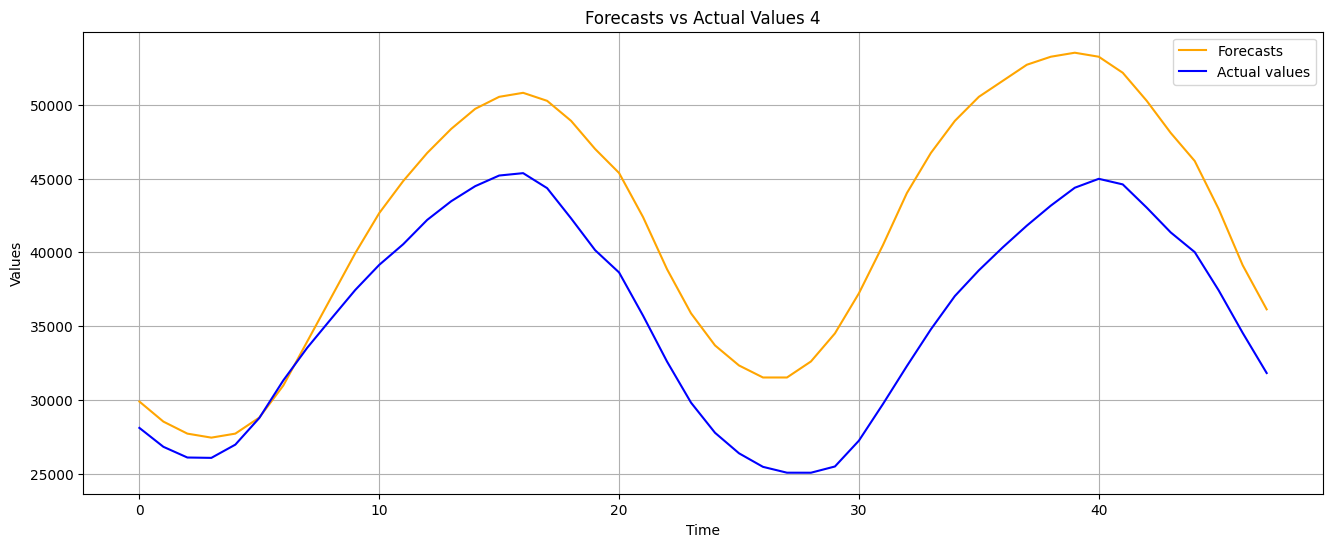

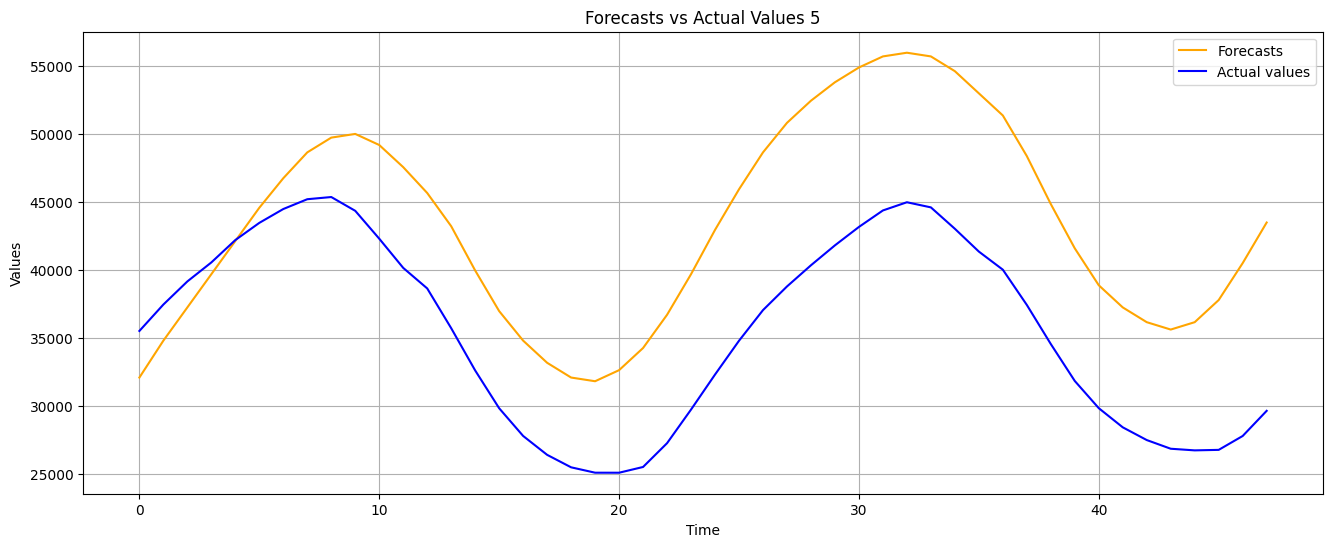

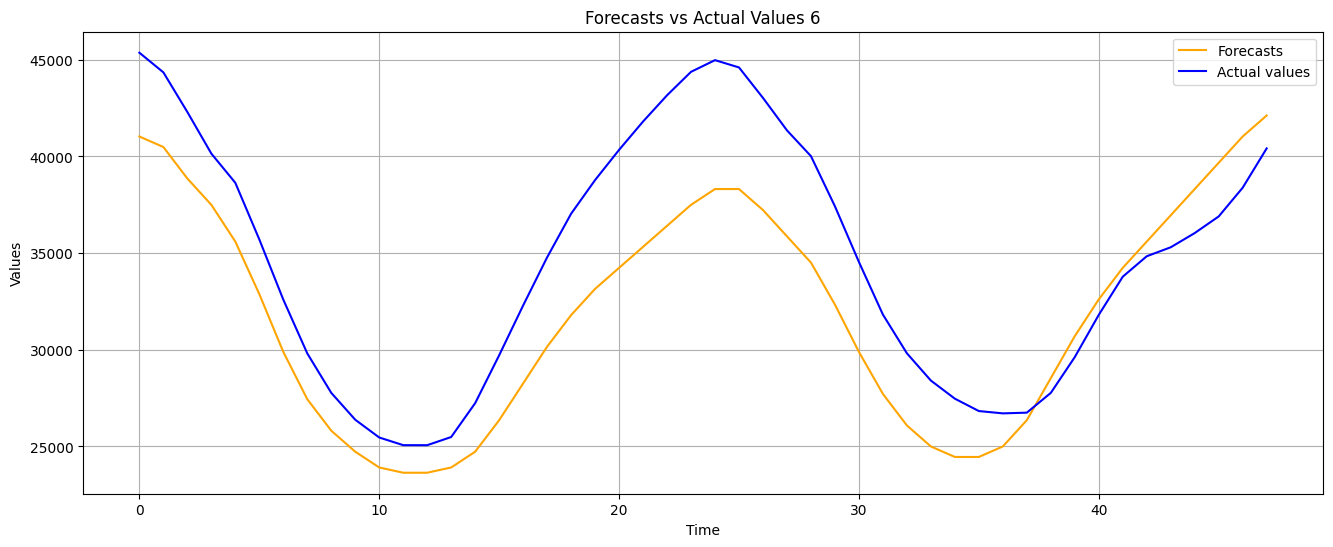

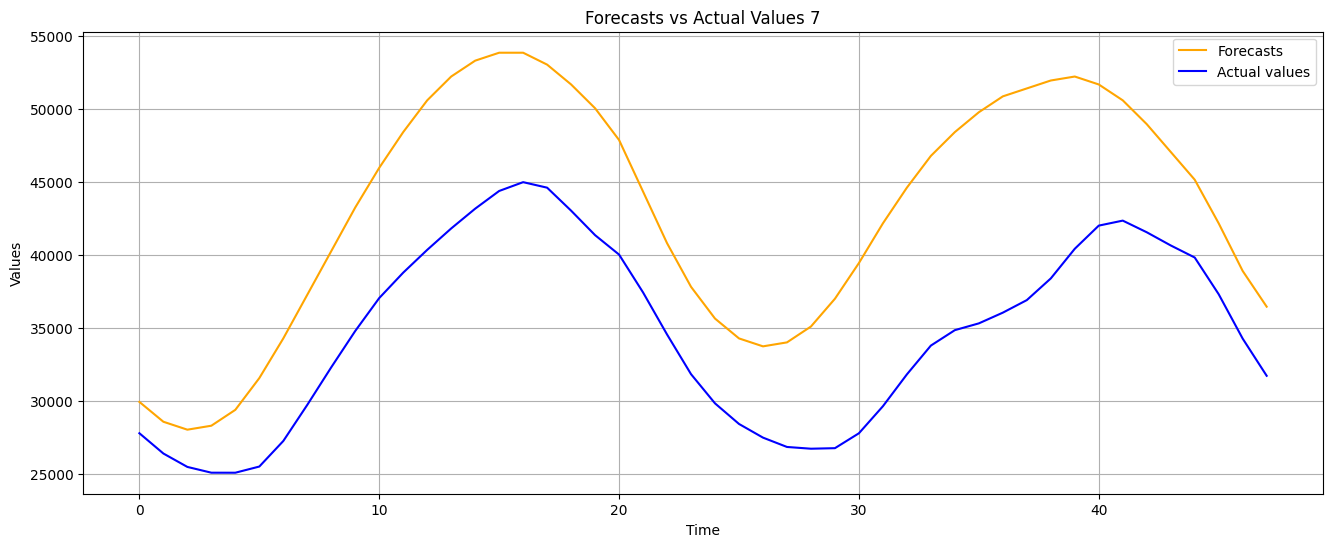

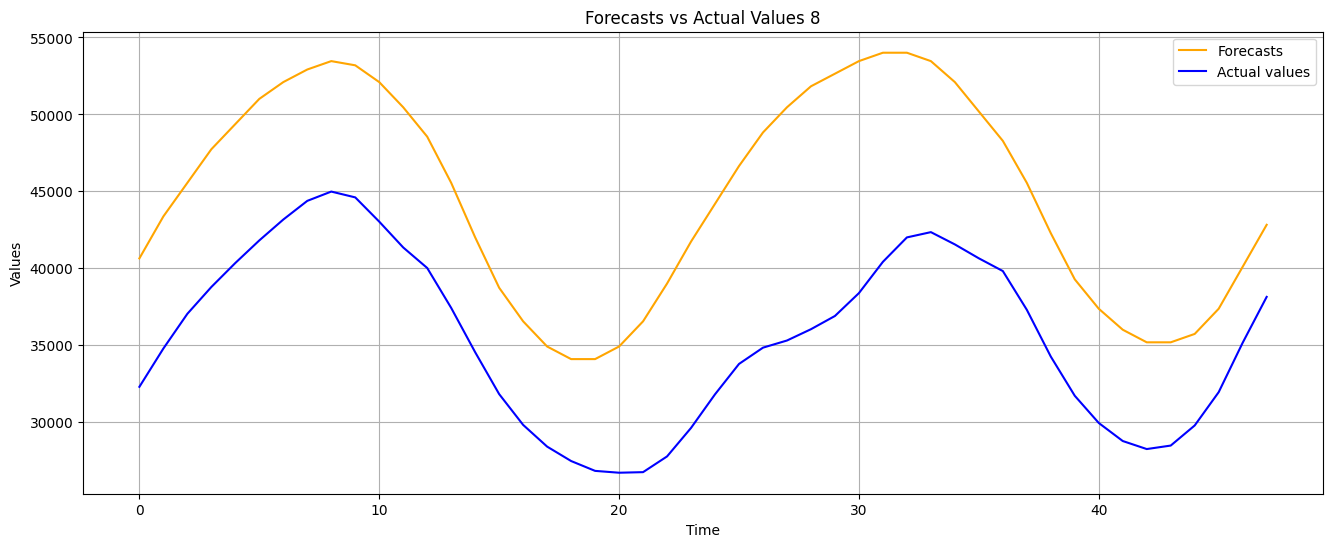

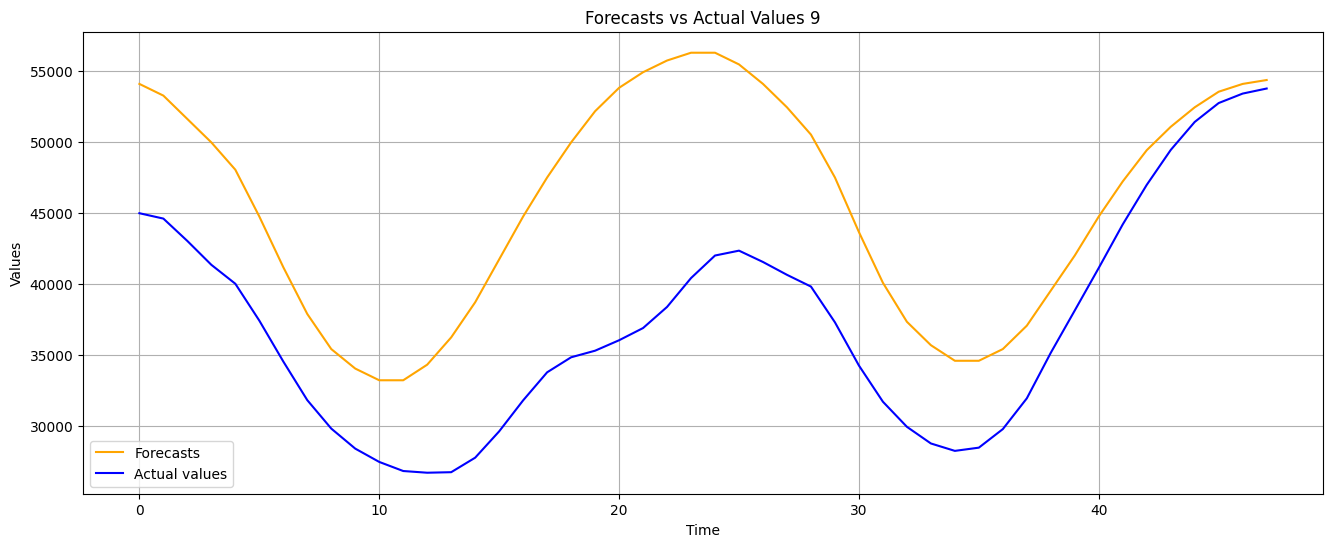

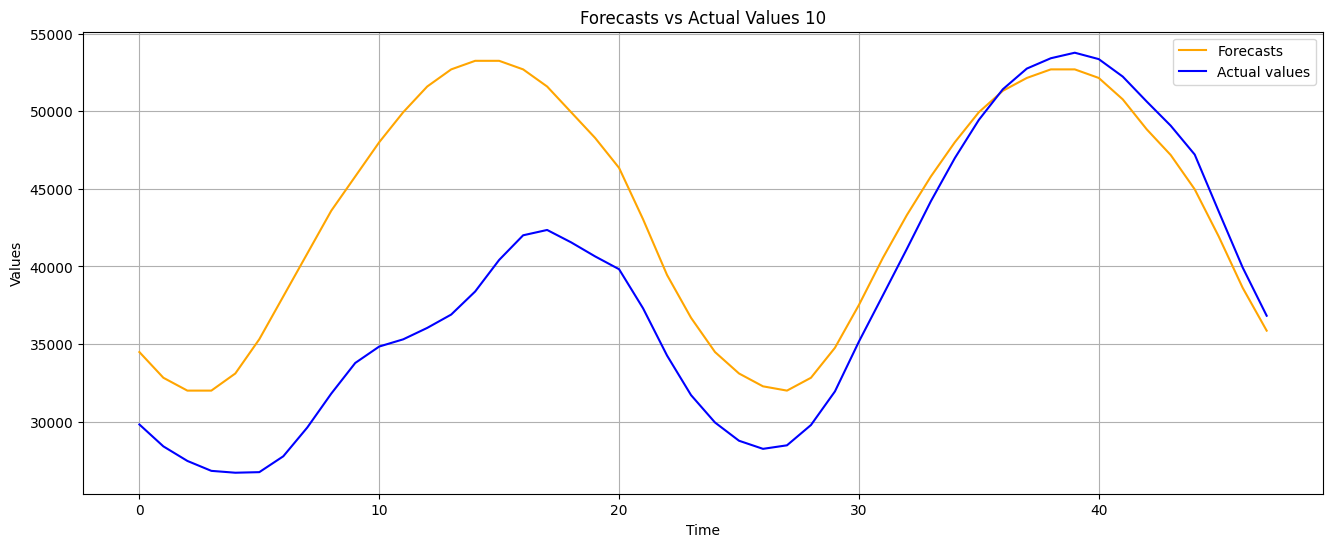

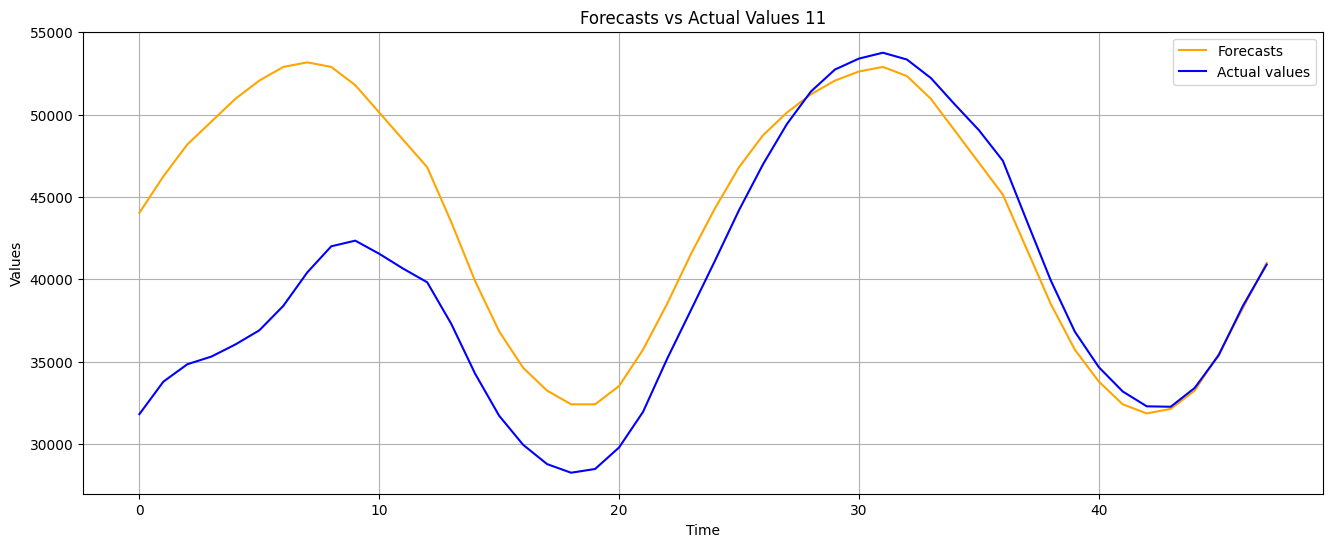

In [16]:
#Plotting 
for i in range(len(forecasts)-43):
    plt.figure(figsize=(16,6))
    plt.plot(forecasts[i],label='Forecasts',color='orange')
    plt.plot(true_vals[i],label='Actual values',color='blue')
    plt.title(f'Forecasts vs Actual Values {i +1}')
    plt.ylabel("Values")
    plt.xlabel('Time')
    plt.legend()
    plt.grid(True)
    plt.show()

# Predicting the Future 

In [17]:
context_data = df.tail(336)

# Convert the numeric values to a tensor
context_tensor = torch.tensor(context_data['PJME_MW'].values, dtype=torch.float32).unsqueeze(0) 

# Predict future values using the Chronos pipeline
forecast = pipeline.predict(
    context=context_tensor,
    temperature=0.1,
    top_k=30,
    top_p=0.9,
    prediction_length=forecast_horizon,
    num_samples=20,
)

# Compute the mean of the forecast samples 
forecast_mean = torch.mean(torch.stack([sample[0].clone().detach() for sample in forecast]), dim=0).numpy()

# Generate the forecast index for future time points
forecast_index = pd.date_range(start=context_data.index[-1] + pd.Timedelta(hours=1), 
                               periods=forecast_horizon, 
                               freq="h")

# Create the forecast series
forecast_series = pd.Series(
    forecast_mean, 
    index=forecast_index 
)

forecast_series = forecast_series.rename("Using Amazon Chronos to predict the future")

# Display the first two predictions for verification
print(forecast_series[:2])

# Predict future values using the Chronos pipeline
forecast = pipeline.predict(
    context=context_tensor,
            temperature=0.5,
            top_k=30,
            top_p=0.75,
            prediction_length=forecast_horizon,
            num_samples=20,
)

# Compute the mean of the forecast samples 
forecast_mean = torch.mean(torch.stack([sample[0].clone().detach() for sample in forecast]), dim=0).numpy()

# Generate the forecast index for future time points
forecast_index = pd.date_range(start=df.index[-1] + pd.Timedelta(hours=1), 
                               periods=forecast_horizon, 
                               freq="h")

# Create the forecast series
forecast_series = pd.Series(
    forecast_mean, 
    index=forecast_index 
)

forecast_series = forecast_series.rename("Using Amazon Chronos to predict the future")

# Display the first two predictions for verification
forecast_series[:2]

2018-08-03 01:00:00    32587.250000
2018-08-03 02:00:00    30501.666016
Freq: h, Name: Using Amazon Chronos to predict the future, dtype: float32


2018-08-03 01:00:00    32847.949219
2018-08-03 02:00:00    31023.062500
Freq: h, Name: Using Amazon Chronos to predict the future, dtype: float32

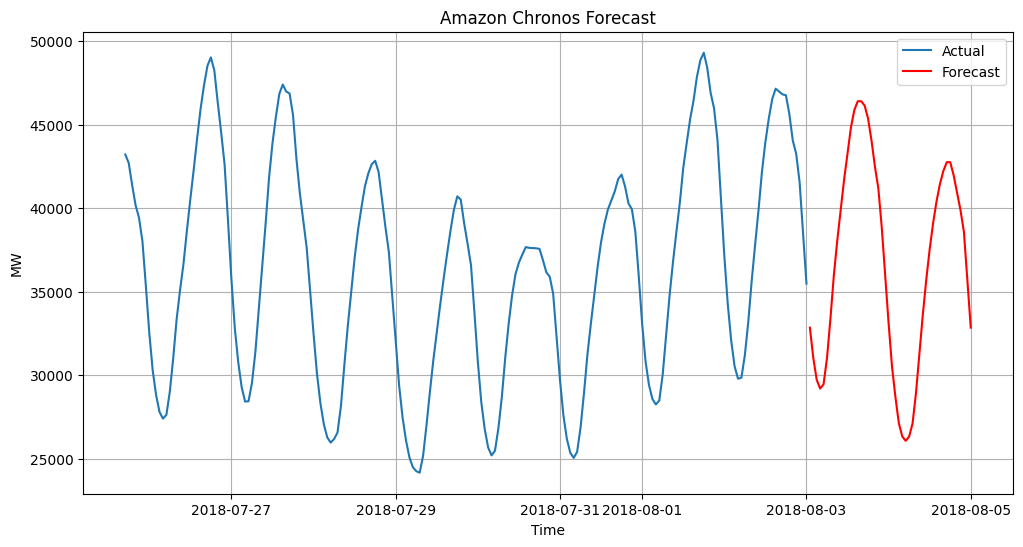

In [18]:
# Plot the df with the forecast
plt.figure(figsize = (12, 6))

# Actual values
plt.plot(df[-200:], label = "Actual")
# Forecast values
plt.plot(forecast_series, label = "Forecast", color = "red")

# Set title, legend, and labels
plt.title("Amazon Chronos Forecast")
plt.ylabel("MW")
plt.xlabel("Time")
plt.legend()
plt.grid(True)
plt.show()

As we apply Amazon Chronos to energy consumption data, we can expect more reliable forecasts that contribute to efficient grid management, cost savings, and better planning for both peak and off-peak hours. Additionally, as Chronos allows for fine-tuning and hyperparameter optimization, it offers flexibility to tailor predictions based on specific needs, whether that’s forecasting for residential, industrial, or commercial use.

In conclusion, by harnessing the power of machine learning and time-series models like Amazon Chronos, we can not only predict future energy demands but also empower decision-makers with the tools needed to drive more efficient and sustainable energy usage in the years to come.